In [1]:
from appgeopy import *

In [2]:
def generate_synthetic_data(
    start_date,
    end_date,
    slope,
    amplitude_annual,
    amplitude_semiannual,
    variance,
):
    dates = pd.date_range(start=start_date, end=end_date, freq="D")
    np.random.seed(42)

    # Create a 1-year seasonal component
    annual_component = amplitude_annual * np.sin(
        2 * np.pi * dates.dayofyear / 365
    )

    # Create a half-year seasonal component
    semiannual_component = amplitude_semiannual * np.sin(
        4 * np.pi * dates.dayofyear / 365
    )

    # Combine the seasonal components
    seasonal_component = annual_component + semiannual_component

    # Create a trend component
    trend_component = slope * (dates - dates[0]).days

    # Create a random noise component
    noise_component = np.random.normal(scale=variance, size=len(dates))

    # Combine all components to create the time-series data
    data = seasonal_component + trend_component + noise_component

    return pd.DataFrame({"date": dates, "value": data}).set_index("date")

(               value
 date                
 2020-01-01  0.565562
 2020-01-02 -0.000619
 2020-01-03  0.854030
 2020-01-04  1.797913
 2020-01-05  0.109069,
 <Axes: xlabel='date'>)

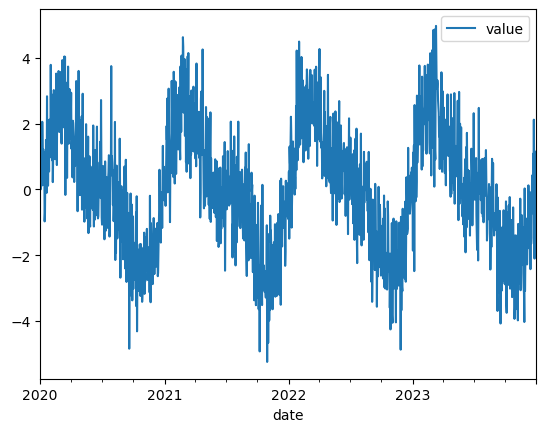

In [3]:
data = generate_synthetic_data(
    start_date="2020-01-01",
    end_date="2023-12-31",
    slope=0,
    amplitude_annual=2,
    amplitude_semiannual=1,
    variance=1,
)
data.head(5), data.plot()

In [4]:
seasonality = analysis.find_seasonality(data, 'value').nlargest(n=10, columns="Amplitude")
seasonality

,Amplitude,Frequency,Phase,Period (days)
0,1.985112,0.002738,-1.551780,365.250000
1,0.975571,0.005476,-1.509929,182.625000
2,0.129425,0.381930,2.002821,2.618280
3,0.128409,0.216290,-3.130758,4.623418
4,0.122298,0.176591,2.366904,5.662791
5,0.118797,0.496235,0.292621,2.015172
6,0.117906,0.297741,-0.381478,3.358621
7,0.114249,0.102669,1.643692,9.740000
8,0.110565,0.432580,1.977837,2.311709
9,0.108631,0.308693,2.948501,3.239468


In [5]:
# Fit the sinusoidal model
time_values = np.arange(len(data))
observed_values = data['value'].values
amplitudes = seasonality['Amplitude'].values
periods = seasonality['Period (days)'].values
phase_shifts = seasonality['Phase'].values
baseline = np.mean(observed_values)

fitted_signal = modeling.fit_sinusoidal_model(
    time_values=time_values,
    observed_values=observed_values,
    amplitudes=amplitudes,
    periods=periods,
    phase_shifts=phase_shifts,
    baseline=baseline
)

fitted_signal = np.roll(fitted_signal, -100)

In [6]:
# Correct phase shift
corrected_signal = analysis.correct_phase_shift(original_data=data, reconstructed_series=fitted_signal, target_column='value')

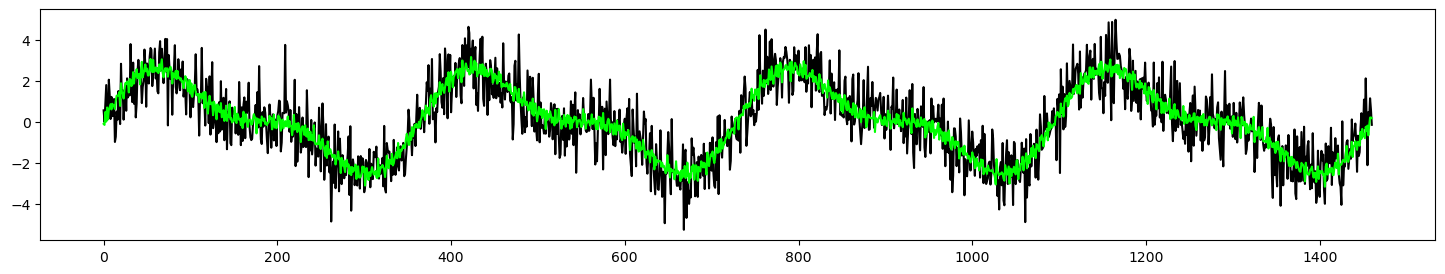

In [7]:
fig = plt.figure(figsize=(18, 3))
ax = fig.add_subplot(111)

ax.plot(data.values, color='black')
ax.plot(corrected_signal, color='lime')